E-COMMERCE PRODUCT RECOMMENDATION SYSTEM

In [56]:
import pandas as pd              
import numpy as np
import matplotlib.pyplot as plt    
from sklearn.metrics import mean_squared_error 
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
       

1.LOAD THE DATA

In [57]:
# File path
file_path = "ratings_Electronics.csv"

# Column names
columns = ['UserID', 'ProductID', 'Rating', 'Timestamp']

# # Reading CSV file and adding column names
df = pd.read_csv(file_path, header=None, names=columns)

# drop timestamp column
df = df.drop('Timestamp', axis=1)

df

,UserID,ProductID,Rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0
...,...,...,...
7824477,A2YZI3C9MOHC0L,BT008UKTMW,5.0
7824478,A322MDK0M89RHN,BT008UKTMW,5.0
7824479,A1MH90R0ADMIK0,BT008UKTMW,4.0
7824480,A10M2KEFPEQDHN,BT008UKTMW,4.0


EXPLORATORY DATA ANALYSIS(EDA)

In [58]:
#shape of the dataset
df.shape

(7824482, 3)

In [59]:
rows=len(df.axes[0])
col=len(df.axes[1])

print(f"rows:{rows}")
print(f"columns:{col}")

rows:7824482
columns:3


In [60]:
#datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   UserID     object 
 1   ProductID  object 
 2   Rating     float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [61]:
# missing values
missing_values=df.isnull().sum()
missing_values

UserID       0
ProductID    0
Rating       0
dtype: int64

2.DATA EXPLORATION

In [62]:
# summary statistics
df.describe()

,Rating
count,7.824482e+06
mean,4.012337e+00
std,1.380910e+00
min,1.000000e+00
25%,3.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,5.000000e+00


With Median 5 and mean 4.01 for ratings shows that most of the users provide positive ratings

In [63]:
# Unique counts
print(df['UserID'].nunique(), 'unique users')
print(df['ProductID'].nunique(), 'unique products')


4201696 unique users
476002 unique products


DATA VISUALIZATION

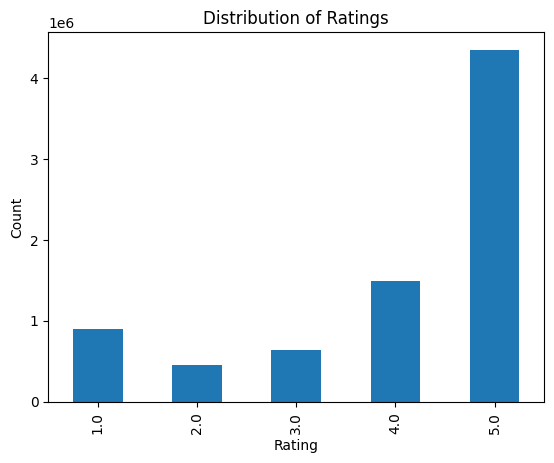

In [64]:
# Distribution of ratings

df['Rating'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()

Distribution of ratings shows that data is highly skewed towards high ratings,with 50% ratings being 5.

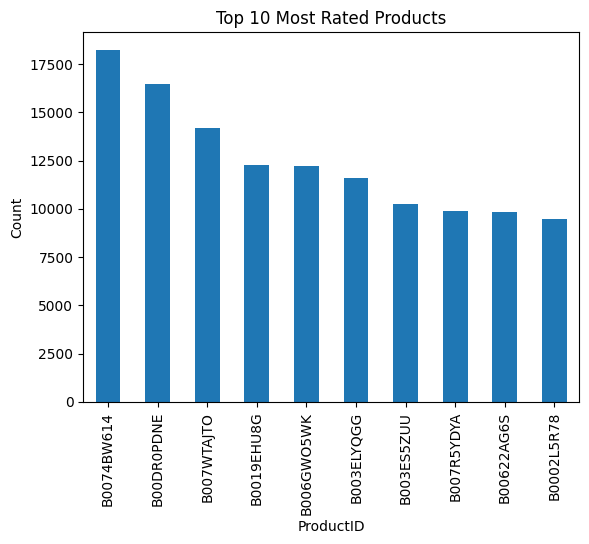

In [65]:
# top 10 most rated products graph

top_rated_products = df['ProductID'].value_counts().head(10)
top_rated_products.plot(kind='bar')
plt.xlabel('ProductID')
plt.ylabel('Count')
plt.title('Top 10 Most Rated Products')
plt.show()


In [66]:
# Top 10 users based on rating
most_rated = df.groupby('UserID').size().sort_values(ascending=False)[:10]
most_rated

UserID
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
dtype: int64

pre processing

keeping the users who have given 50 or more ratings to make the dataset less sparse and easy to work with.

In [67]:
counts = df['UserID'].value_counts()
df_final = df[df['UserID'].isin(counts[counts >= 50].index)]


In [68]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['UserID'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['ProductID'].nunique())

The number of observations in the final data = 125871
Number of unique USERS in the final data =  1540
Number of unique PRODUCTS in the final data =  48190


We will use df_final to build recommendation systems

In [69]:
#Checking the density of the rating matrix

#Creating the interaction matrix of products and users based on ratings and replacing NaN value with 0
final_ratings_matrix = df_final.pivot(index = 'UserID', columns ='ProductID', values = 'Rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

#Finding the number of non-zero entries in the interaction matrix 
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

#Finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

#Density of ratings
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

final_ratings_matrix.head()

Shape of final_ratings_matrix:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
UserID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


MODEL BASED COLLABORATIVE FILTERING : SINGLE VALUE DECOMPOSITION

SVD is best to apply on a large sparse matrix.

In [70]:
# Convert the dense matrix to a sparse matrix
sparse_ratings_matrix = csr_matrix(final_ratings_matrix)

# Now perform SVD on the sparse matrix
U, sigma, Vt = svds(sparse_ratings_matrix, k=2)  # Use k=2 for the small dataset

# Convert sigma to diagonal     matrix form
sigma = np.diag(sigma)


In [71]:
# Making predictions
predicted_ratings = np.dot(np.dot(U, sigma), Vt)

# # Adding the user means back to get the actual predicted ratings
# predicted_ratings += final_ratings_matrix.mean(axis=1).values.reshape(-1, 1)

# Convert to DataFrame for easier interpretation
predicted_ratings_df = pd.DataFrame(predicted_ratings, columns=final_ratings_matrix.columns)

# Displaying the first few predicted ratings
predicted_ratings_df.head()

ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.000968,0.001778,0.002922,0.007684,0.001689,0.001149,0.001004,0.000567,0.007274,0.001075,...,0.000164,0.052447,0.001862,0.070809,0.006479,0.007502,0.000056,0.176923,0.068707,0.012639
1,0.001314,0.001371,0.004446,0.018411,0.008926,0.000925,0.009780,0.002382,0.007235,0.000918,...,0.000342,0.014690,0.000952,-0.007267,0.010095,-0.000958,0.002212,-0.007692,-0.005066,0.000708
2,0.001054,0.000834,0.003690,0.016808,0.008854,0.000581,0.009994,0.002323,0.005132,0.000598,...,0.000305,-0.002624,0.000362,-0.032198,0.008432,-0.003610,0.002320,-0.069384,-0.029143,-0.003627
3,0.000296,0.000442,0.000939,0.003120,0.001158,0.000290,0.001122,0.000329,0.001966,0.000276,...,0.000062,0.010547,0.000416,0.011616,0.002105,0.001213,0.000224,0.030037,0.011463,0.002267
4,0.000667,0.000612,0.002297,0.009995,0.005069,0.000419,0.005647,0.001340,0.003462,0.000422,...,0.000184,0.002902,0.000357,-0.012033,0.005232,-0.001385,0.001296,-0.023906,-0.010507,-0.000968


In [72]:
preds_matrix = csr_matrix(predicted_ratings_df.values)

In [77]:
#Function to recommend products

def recommend_items(user_index, interactions_matrix, preds_matrix, num_recommendations):
    
    # Get the user's ratings from the actual and predicted interaction matrices
    user_ratings = interactions_matrix[user_index,:].toarray().reshape(-1)
    user_predictions = preds_matrix[user_index,:].toarray().reshape(-1)

    #Creating a dataframe with actual and predicted ratings columns
    temp = pd.DataFrame({'user_ratings': user_ratings, 'user_predictions': user_predictions})
    temp['Recommended Products'] = np.arange(len(user_ratings))
    temp = temp.set_index('Recommended Products')
    
    #Filtering the dataframe where actual ratings are 0 which implies that the user has not interacted with that product
    temp = temp.loc[temp.user_ratings == 0]   
    
    #Recommending products with top predicted ratings
    temp = temp.sort_values('user_predictions',ascending=False)#Sort the dataframe by user_predictions in descending order
    print('\nBelow are the recommended products for user(user_id = {}):\n'.format(user_index))
    print(temp['user_predictions'].head(num_recommendations))


In [78]:
#Enter 'user index' and 'num_recommendations' for the user
recommend_items(121,sparse_ratings_matrix,preds_matrix,5)


Below are the recommended products for user(user_id = 121):

Recommended Products
39003    1.640624
38615    1.321267
28761    1.150749
38611    1.108283
21982    1.083377
Name: user_predictions, dtype: float64


In [79]:

recommend_items(100,sparse_ratings_matrix,preds_matrix,10)


Below are the recommended products for user(user_id = 100):

Recommended Products
11078    1.560740
38615    1.486249
28761    1.270907
38611    1.224395
28763    1.020000
23378    0.919093
38614    0.873256
38655    0.871242
38656    0.845123
47142    0.812483
Name: user_predictions, dtype: float64


In [80]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
average_rating = final_ratings_matrix.mean()
average_rating.head()

ProductID
0594451647    0.003247
0594481813    0.001948
0970407998    0.003247
0972683275    0.012338
1400501466    0.012987
dtype: float64

In [82]:
predicted_ratings_df.head()

ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.000968,0.001778,0.002922,0.007684,0.001689,0.001149,0.001004,0.000567,0.007274,0.001075,...,0.000164,0.052447,0.001862,0.070809,0.006479,0.007502,0.000056,0.176923,0.068707,0.012639
1,0.001314,0.001371,0.004446,0.018411,0.008926,0.000925,0.009780,0.002382,0.007235,0.000918,...,0.000342,0.014690,0.000952,-0.007267,0.010095,-0.000958,0.002212,-0.007692,-0.005066,0.000708
2,0.001054,0.000834,0.003690,0.016808,0.008854,0.000581,0.009994,0.002323,0.005132,0.000598,...,0.000305,-0.002624,0.000362,-0.032198,0.008432,-0.003610,0.002320,-0.069384,-0.029143,-0.003627
3,0.000296,0.000442,0.000939,0.003120,0.001158,0.000290,0.001122,0.000329,0.001966,0.000276,...,0.000062,0.010547,0.000416,0.011616,0.002105,0.001213,0.000224,0.030037,0.011463,0.002267
4,0.000667,0.000612,0.002297,0.009995,0.005069,0.000419,0.005647,0.001340,0.003462,0.000422,...,0.000184,0.002902,0.000357,-0.012033,0.005232,-0.001385,0.001296,-0.023906,-0.010507,-0.000968


In [84]:
avg_preds=predicted_ratings_df.mean()
avg_preds.head()
     

ProductID
0594451647    0.000665
0594481813    0.000810
0970407998    0.002197
0972683275    0.008428
1400501466    0.003778
dtype: float64

In [85]:
rmse_df = pd.concat([average_rating, avg_preds], axis=1)

rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']

rmse_df.head()

,Avg_actual_ratings,Avg_predicted_ratings
ProductID,,
0594451647,0.003247,0.000665
0594481813,0.001948,0.000810
0970407998,0.003247,0.002197
0972683275,0.012338,0.008428
1400501466,0.012987,0.003778


In [86]:
#RMSE calculation

RMSE=mean_squared_error(rmse_df['Avg_actual_ratings'], rmse_df['Avg_predicted_ratings'], squared=False)
print(f'RMSE SVD Model = {RMSE} \n')
     

RMSE SVD Model = 0.005630685676244657 

